In [1]:
# use seastar Kernel on adrien local nov laptop

import os
import xarray as xr
import numpy as np
# import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs # => to add in Seastar env
import seastar
from seastar.utils.tools import dotdict, lin2db
from seastar.performance import scene_generation

from scipy import interpolate, stats # => to add in Seastar env ?
from scipy.optimize import least_squares

# from seastar.gmfs.doppler import *

ImportError: cannot import name 'dotdict' from 'seastar.utils.tools' (/Users/admartin/OneDrive/OneDrive - NOC/Documents/NOC-OneDrive/workLocal/SEASTAR/seastar/seastar/utils/tools.py)

In [2]:
SciReC_simu = '../'

# Analysis as function of Wind Dir.

In [3]:
nickname = '3base'
version = 'v20230609'

In [4]:
input_wdir_list = np.arange(0,360,15)
level2_tmp = [None] * len(input_wdir_list)
truth_tmp = [None] * len(input_wdir_list)
for ii, inwdir in enumerate(input_wdir_list):
    filename = '3base_3AC15_35_011x100_SNKp03RSV07_MVNKp04RSVnan_W005_{:03.0f}_C0.6_150_N4DS_M12'.format(inwdir)
    filename_l2 = 'level2_' + filename + '_' + version + '.nc'
    filename_truth = 'truth_' + filename + '.nc'
    level2_tmp[ii] = xr.open_dataset(os.path.join(SciReC_simu,'level2s',version,filename_l2))
    level2_tmp[ii]['input_wdir'] = inwdir
    truth_tmp[ii] = xr.open_dataset(os.path.join(SciReC_simu,'truths',version,filename_truth))
    truth_tmp[ii]['input_wdir'] = inwdir
level2 = xr.concat(level2_tmp, dim='input_wdir')
truth = xr.concat(truth_tmp, dim='input_wdir')

In [5]:
for var in level2.x_variables.data:
    level2[var] = level2.x.sel(x_variables=var)

In [6]:
level2

<xarray.Dataset>
Dimensions:              (across: 11, along: 100, x_variables: 4,
                          Observables: 2, Antenna: 3, input_wdir: 24,
                          Ambiguities: 4, fun_variables: 6, extrema: 2)
Coordinates:
  * across               (across) float64 -53.57 -32.14 -10.71 ... 145.2 169.2
  * along                (along) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
  * x_variables          (x_variables) object 'u' 'v' 'c_u' 'c_v'
  * Observables          (Observables) object 'sigma0' 'RSV'
  * Antenna              (Antenna) object 'Fore' 'MidV' 'Aft'
    fun_variables        (Observables, Antenna) int64 0 1 2 3 4 5
    CentralFreq          float64 1.35e+10
    AntennaAzimuthImage  (Antenna, across, along) float64 33.51 33.51 ... 125.5
    Polarization         (Antenna) object 'VV' 'VV' 'VV'
    IncidenceAngleImage  (Antenna, across, along) float64 28.52 28.52 ... 41.12
  * input_wdir           (input_wdir) int64 0 15 30 45 60 ... 300 315 330 345
Dimensions without coordinates: Ambiguities, extrema
Data variables: (12/21)
    x                    (input_wdir, Ambiguities, x_variables, across, along) float64 ...
    active_mask          (input_wdir, Ambiguities, x_variables, across, along) int64 ...
    grad                 (input_wdir, Ambiguities, x_variables, across, along) float64 ...
    fun                  (input_wdir, Ambiguities, Observables, Antenna, across, along) float64 ...
    jac                  (input_wdir, Ambiguities, fun_variables, x_variables, across, along) float64 ...
    x0                   (input_wdir, Ambiguities, x_variables, across, along) float64 ...
    ...                   ...
    x_scale              (input_wdir, x_variables, across, along) float64 7.0...
    bounds               (input_wdir, extrema, x_variables, across, along) int64 ...
    u                    (input_wdir, Ambiguities, across, along) float64 2.7...
    v                    (input_wdir, Ambiguities, across, along) float64 1.2...
    c_u                  (input_wdir, Ambiguities, across, along) float64 -0....
    c_v                  (input_wdir, Ambiguities, across, along) float64 -2....
Attributes:
    inst:     ../instruments/inst_3base_3AC15_35_011x_SNKp03RSV07_MVNKp04RSVn...
    geo:      ../geo/geo_011x100_W005_000_C0.6_150.nc
    truth:    ../truths/truth_3base_3AC15_35_011x100_SNKp03RSV07_MVNKp04RSVna...
    level1:   ../level1s/level1_3base_3AC15_35_011x100_SNKp03RSV07_MVNKp04RSV...

In [7]:
ambiguity_list = [
    {'name': 'sort_by_cost', 'method': 'sort_by_cost'},
    {'name': 'closest_truth', 'truth': truth, 'method': 'windcurrent'},
#     {'name': 'closest_truth', 'truth': truth, 'method': 'wind'}, # => bug in concat below
    {'name': 'closest_truth'g},
]
sol_list = [None] * len(ambiguity_list)
ambiguity_names = [None] * len(ambiguity_list)

for ii in range(len(sol_list)):
    sol_list[ii] = seastar.retrieval.ambiguity_removal.solve_ambiguity(level2, ambiguity_list[ii])
    ambiguity_names[ii] = ambiguity_list[ii]['method']

sol = xr.concat(sol_list, dim='ambiguity_names')
sol.coords['ambiguity_names'] = ambiguity_names

In [8]:
level2b = seastar.retrieval.level2.sol2level2(sol)
level2b

<xarray.Dataset>
Dimensions:                     (across: 11, along: 100, x_variables: 4,
                                 Observables: 2, Antenna: 3, input_wdir: 24,
                                 ambiguity_names: 3)
Coordinates: (12/13)
    x_reduce                    <U4 'c_uv'
  * across                      (across) float64 -53.57 -32.14 ... 145.2 169.2
  * along                       (along) int64 0 1 2 3 4 5 ... 94 95 96 97 98 99
  * x_variables                 (x_variables) object 'u' 'v' 'c_u' 'c_v'
  * Observables                 (Observables) object 'sigma0' 'RSV'
  * Antenna                     (Antenna) object 'Fore' 'MidV' 'Aft'
    ...                          ...
    CentralFreq                 float64 1.35e+10
    AntennaAzimuthImage         (Antenna, across, along) float64 33.51 ... 125.5
    Polarization                (Antenna) object 'VV' 'VV' 'VV'
    IncidenceAngleImage         (Antenna, across, along) float64 28.52 ... 41.12
  * input_wdir                  (input_wdir) int64 0 15 30 45 ... 315 330 345
  * ambiguity_names             (ambiguity_names) <U12 'sort_by_cost' ... 'cu...
Data variables: (12/14)
    x                           (ambiguity_names, input_wdir, across, along, x_variables) float64 ...
    cost                        (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentU                    (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentV                    (ambiguity_names, input_wdir, across, along) float64 ...
    EarthRelativeWindU          (ambiguity_names, input_wdir, across, along) float64 ...
    EarthRelativeWindV          (ambiguity_names, input_wdir, across, along) float64 ...
    ...                          ...
    OceanSurfaceWindSpeed       (ambiguity_names, input_wdir, across, along) float64 ...
    OceanSurfaceWindDirection   (ambiguity_names, input_wdir, across, along) float64 ...
    EarthRelativeWindSpeed      (ambiguity_names, input_wdir, across, along) float64 ...
    EarthRelativeWindDirection  (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentVelocity             (ambiguity_names, input_wdir, across, along) float64 ...
    CurrentDirection            (ambiguity_names, input_wdir, across, along) float64 ...
Attributes:
    inst:     ../instruments/inst_3base_3AC15_35_011x_SNKp03RSV07_MVNKp04RSVn...
    geo:      ../geo/geo_011x100_W005_000_C0.6_150.nc
    truth:    ../truths/truth_3base_3AC15_35_011x100_SNKp03RSV07_MVNKp04RSVna...
    level1:   ../level1s/level1_3base_3AC15_35_011x100_SNKp03RSV07_MVNKp04RSV...

In [25]:
truth

<xarray.Dataset>
Dimensions:                     (across: 11, Antenna: 3, along: 100,
                                 input_wdir: 24)
Coordinates:
    IncidenceAngleImage         (across, Antenna, along) float64 28.52 ... 41.12
    AntennaAzimuthImage         (across, Antenna, along) float64 33.51 ... 125.5
    Polarization                (across, Antenna, along) object 'VV' ... 'VV'
    CentralFreq                 float64 1.35e+10
  * across                      (across) float64 -53.57 -32.14 ... 145.2 169.2
  * Antenna                     (Antenna) object 'Fore' 'MidV' 'Aft'
  * along                       (along) int64 0 1 2 3 4 5 ... 94 95 96 97 98 99
  * input_wdir                  (input_wdir) int64 0 15 30 45 ... 315 330 345
Data variables: (12/18)
    uncerty_Kp                  (input_wdir, across, Antenna, along) float64 ...
    uncerty_RSV                 (input_wdir, across, Antenna, along) float64 ...
    Sigma0                      (input_wdir, Antenna, across, along) float64 ...
    RSV                         (input_wdir, Antenna, across, along) float64 ...
    EarthRelativeWindSpeed      (input_wdir, across, along) int64 5 5 5 ... 5 5
    EarthRelativeWindDirection  (input_wdir, across, along) int64 0 0 ... 345
    ...                          ...
    OceanSurfaceWindU           (input_wdir, across, along) float64 -0.3 ... ...
    OceanSurfaceWindV           (input_wdir, across, along) float64 -4.48 ......
    OceanSurfaceWindSpeed       (input_wdir, across, along) float64 4.49 ... ...
    OceanSurfaceWindDirection   (input_wdir, across, along) float64 3.831 ......
    WindSpeed                   (input_wdir, across, along) float64 4.49 ... ...
    WindDirection               (input_wdir, across, along) float64 3.831 ......
Attributes:
    gmf_nrcs:     nscat4ds
    gmf_doppler:  mouche12
    inst:         ../instruments/inst_3base_3AC15_35_011x_SNKp03RSV07_MVNKp04...
    geo:          ../geo/geo_011x100_W005_000_C0.6_150.nc

In [11]:
err = level2b - truth
err['flag'] = level2b.cost > 4

In [21]:
colorlinewidth = .5

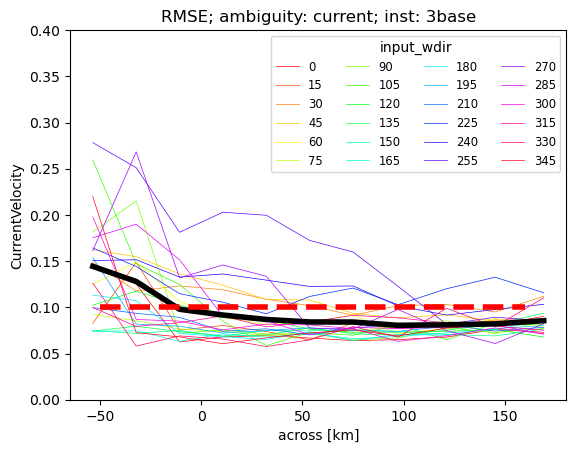

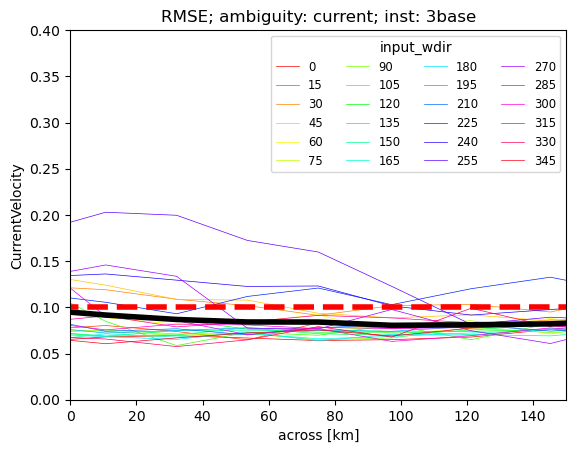

In [47]:
rmse = np.sqrt((err['CurrentVelocity'].where(~err.flag)**2).mean(dim='along'))\
            .sel(ambiguity_names='current')

fig, ax = plt.subplots()
cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
ax.set_prop_cycle("color", cmap)
g=rmse.plot(hue='input_wdir',linewidth=colorlinewidth)# add_legend=True,)# add_colorbar=True)
rmse.mean(dim='input_wdir').plot(color='k', linewidth=4)
plt.plot([-50, 160], [0.1, 0.1], 'r--', lw=4)
plt.ylim([0,0.4])
plt.title('RMSE; ambiguity: current' + '; inst: ' + nickname)
ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')


fig, ax = plt.subplots()
cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
ax.set_prop_cycle("color", cmap)
g=rmse.plot(hue='input_wdir',linewidth=colorlinewidth)# add_legend=True,)# add_colorbar=True)
rmse.mean(dim='input_wdir').plot(color='k', linewidth=4)
plt.plot([-50, 160], [0.1, 0.1], 'r--', lw=4)
plt.ylim([0,0.4])
plt.xlim([0,150])
plt.title('RMSE; ambiguity: current' + '; inst: ' + nickname)
ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

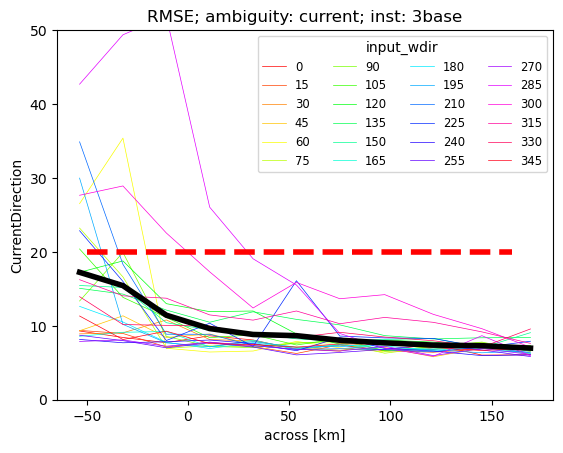

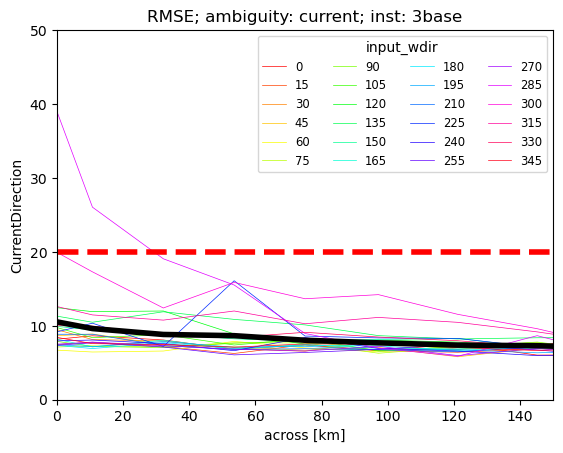

In [48]:
rmse = np.sqrt((err['CurrentDirection'].where(~err.flag)**2).mean(dim='along'))\
            .sel(ambiguity_names='current')

fig, ax = plt.subplots()
cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
ax.set_prop_cycle("color", cmap)
g=rmse.plot(hue='input_wdir',linewidth=colorlinewidth)# add_legend=True,)# add_colorbar=True)
rmse.mean(dim='input_wdir').plot(color='k', linewidth=4)
plt.plot([-50, 160], [20, 20], 'r--', lw=4)
plt.ylim([0,50])
plt.title('RMSE; ambiguity: current' + '; inst: ' + nickname)
ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

fig, ax = plt.subplots()
cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
ax.set_prop_cycle("color", cmap)
g=rmse.plot(hue='input_wdir',linewidth=colorlinewidth)# add_legend=True,)# add_colorbar=True)
rmse.mean(dim='input_wdir').plot(color='k', linewidth=4)
plt.plot([-50, 160], [20, 20], 'r--', lw=4)
plt.ylim([0,50])
plt.xlim([0,150])
plt.title('RMSE; ambiguity: current' + '; inst: ' + nickname)
ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

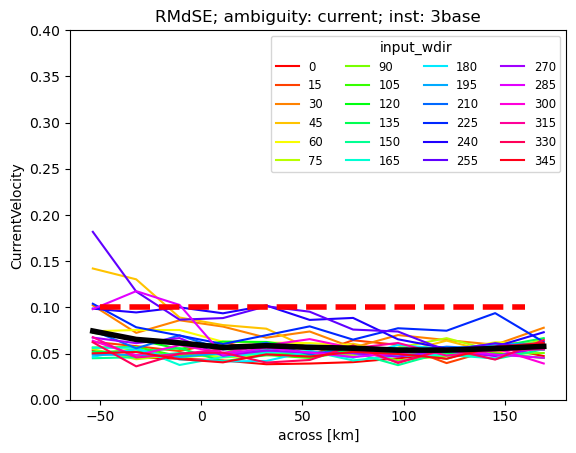

In [15]:
rmse = np.sqrt((err['CurrentVelocity'].where(~err.flag)**2).median(dim='along'))\
            .sel(ambiguity_names='current')

fig, ax = plt.subplots()
cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
ax.set_prop_cycle("color", cmap)
g=rmse.plot(hue='input_wdir',)# add_legend=True,)# add_colorbar=True)
rmse.mean(dim='input_wdir').plot(color='k', linewidth=4)
plt.plot([-50, 160], [0.1, 0.1], 'r--', lw=4)
plt.ylim([0,0.4])
plt.title('RMdSE; ambiguity: current' + '; inst: ' + nickname)
ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

Text(0.5, 1.0, 'RMSE; ambiguity: current; inst: 3base')

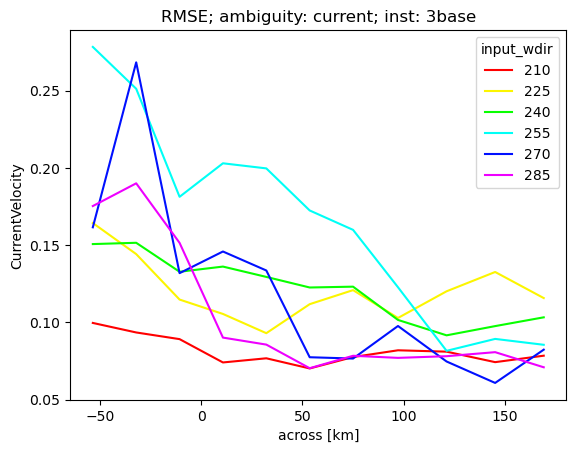

In [21]:
fig, ax = plt.subplots()
cmap = plt.cm.hsv(np.linspace(0,1,7))
ax.set_prop_cycle("color", cmap)
np.sqrt((err['CurrentVelocity'].where(~err.flag)**2).mean(dim='along'))\
    .sel(input_wdir=[210, 225, 240, 255, 270, 285])\
    .sel(ambiguity_names='current')\
    .plot(hue='input_wdir',)# add_legend=False)
plt.title('RMSE; ambiguity: current' + '; inst: ' + nickname)

#### Wind

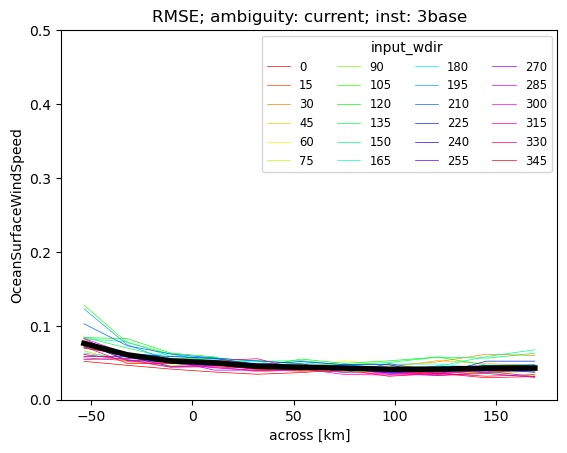

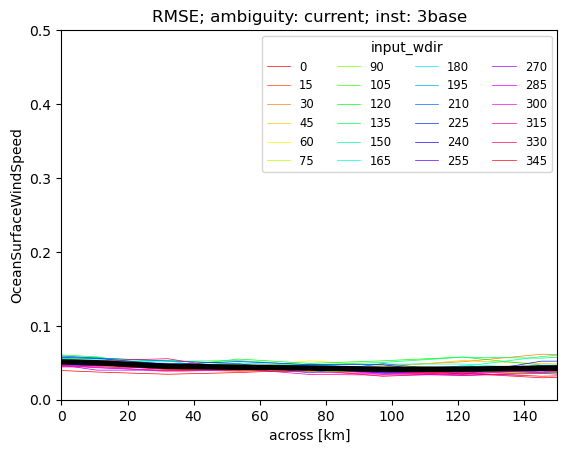

In [49]:
rmse = np.sqrt((err['OceanSurfaceWindSpeed'].where(~err.flag)**2).mean(dim='along'))\
            .sel(ambiguity_names='current')

fig, ax = plt.subplots()
cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
ax.set_prop_cycle("color", cmap)
g=rmse.plot(hue='input_wdir',linewidth=colorlinewidth)# add_legend=True,)# add_colorbar=True)
rmse.mean(dim='input_wdir').plot(color='k', linewidth=4)
# plt.plot([-50, 160], [0.1, 0.1], 'r--', lw=4)
plt.ylim([0,.5])
plt.title('RMSE; ambiguity: current' + '; inst: ' + nickname)
ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

fig, ax = plt.subplots()
cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
ax.set_prop_cycle("color", cmap)
g=rmse.plot(hue='input_wdir',linewidth=colorlinewidth)# add_legend=True,)# add_colorbar=True)
rmse.mean(dim='input_wdir').plot(color='k', linewidth=4)
# plt.plot([-50, 160], [0.1, 0.1], 'r--', lw=4)
plt.ylim([0,.5])
plt.xlim([0,150])
plt.title('RMSE; ambiguity: current' + '; inst: ' + nickname)
ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

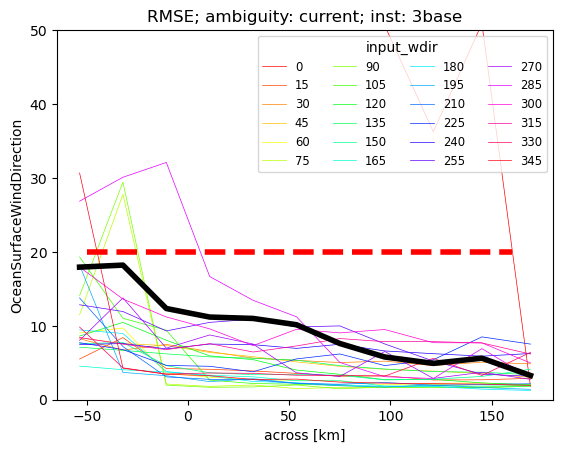

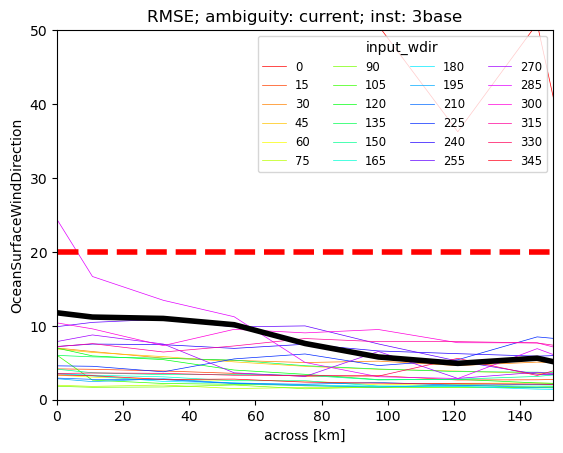

In [50]:
rmse = np.sqrt((err['OceanSurfaceWindDirection'].where(~err.flag)**2).mean(dim='along'))\
            .sel(ambiguity_names='current')

fig, ax = plt.subplots()
cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
ax.set_prop_cycle("color", cmap)
g=rmse.plot(hue='input_wdir',linewidth=colorlinewidth)# add_legend=True,)# add_colorbar=True)
rmse.mean(dim='input_wdir').plot(color='k', linewidth=4)
plt.plot([-50, 160], [20, 20], 'r--', lw=4)
plt.ylim([0,50])
plt.title('RMSE; ambiguity: current' + '; inst: ' + nickname)
ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

fig, ax = plt.subplots()
cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
ax.set_prop_cycle("color", cmap)
g=rmse.plot(hue='input_wdir',linewidth=colorlinewidth)# add_legend=True,)# add_colorbar=True)
rmse.mean(dim='input_wdir').plot(color='k', linewidth=4)
plt.plot([-50, 160], [20, 20], 'r--', lw=4)
plt.ylim([0,50])
plt.xlim([0,150])
plt.title('RMSE; ambiguity: current' + '; inst: ' + nickname)
ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

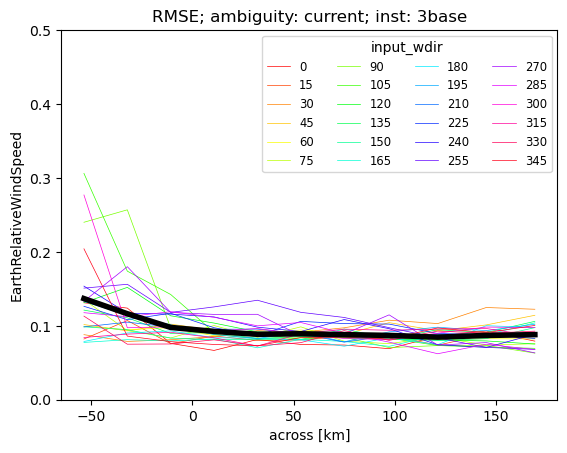

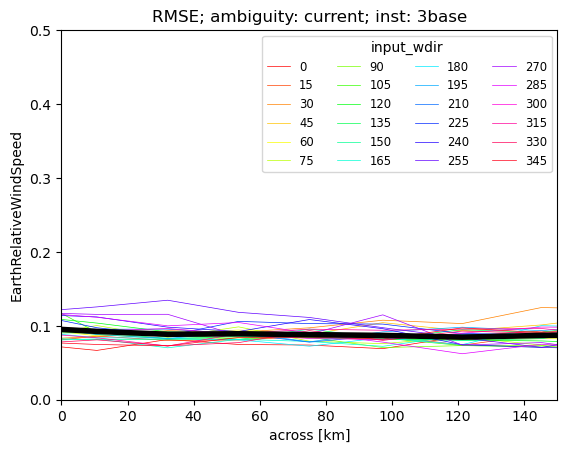

In [51]:
rmse = np.sqrt((err['EarthRelativeWindSpeed'].where(~err.flag)**2).mean(dim='along'))\
            .sel(ambiguity_names='current')

fig, ax = plt.subplots()
cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
ax.set_prop_cycle("color", cmap)
g=rmse.plot(hue='input_wdir',linewidth=colorlinewidth)# add_legend=True,)# add_colorbar=True)
rmse.mean(dim='input_wdir').plot(color='k', linewidth=4)
# plt.plot([-50, 160], [0.1, 0.1], 'r--', lw=4)
plt.ylim([0,.5])
plt.title('RMSE; ambiguity: current' + '; inst: ' + nickname)
ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

fig, ax = plt.subplots()
cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
ax.set_prop_cycle("color", cmap)
g=rmse.plot(hue='input_wdir',linewidth=colorlinewidth)# add_legend=True,)# add_colorbar=True)
rmse.mean(dim='input_wdir').plot(color='k', linewidth=4)
# plt.plot([-50, 160], [0.1, 0.1], 'r--', lw=4)
plt.ylim([0,.5])
plt.xlim([0,150])
plt.title('RMSE; ambiguity: current' + '; inst: ' + nickname)
ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

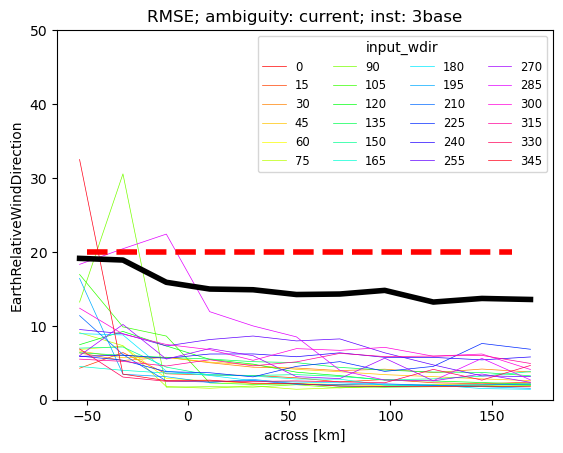

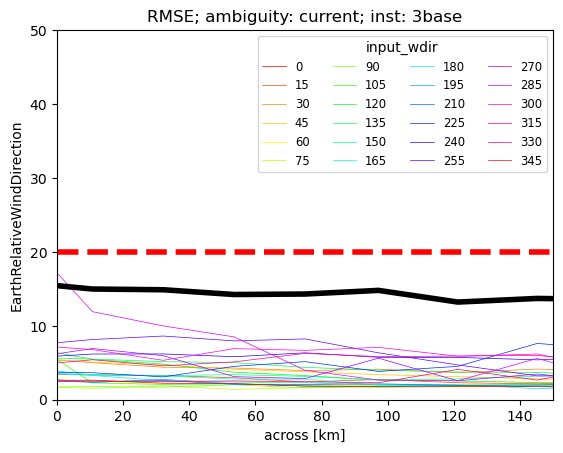

In [52]:
rmse = np.sqrt((err['EarthRelativeWindDirection'].where(~err.flag)**2).mean(dim='along'))\
            .sel(ambiguity_names='current')

fig, ax = plt.subplots()
cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
ax.set_prop_cycle("color", cmap)
g=rmse.plot(hue='input_wdir',linewidth=colorlinewidth)# add_legend=True,)# add_colorbar=True)
rmse.mean(dim='input_wdir').plot(color='k', linewidth=4)
plt.plot([-50, 160], [20, 20], 'r--', lw=4)
plt.ylim([0,50])
plt.title('RMSE; ambiguity: current' + '; inst: ' + nickname)
ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

fig, ax = plt.subplots()
cmap = plt.cm.hsv(np.linspace(0,1,len(err.input_wdir)))
ax.set_prop_cycle("color", cmap)
g=rmse.plot(hue='input_wdir',linewidth=colorlinewidth)# add_legend=True,)# add_colorbar=True)
rmse.mean(dim='input_wdir').plot(color='k', linewidth=4)
plt.plot([-50, 160], [20, 20], 'r--', lw=4)
plt.ylim([0,50])
plt.xlim([0,150])
plt.title('RMSE; ambiguity: current' + '; inst: ' + nickname)
ax.legend(rmse.input_wdir.data, title='input_wdir', loc='upper right', ncol=4, fontsize='small')

Text(0.5, 1.03, 'Current; inst: 3base')

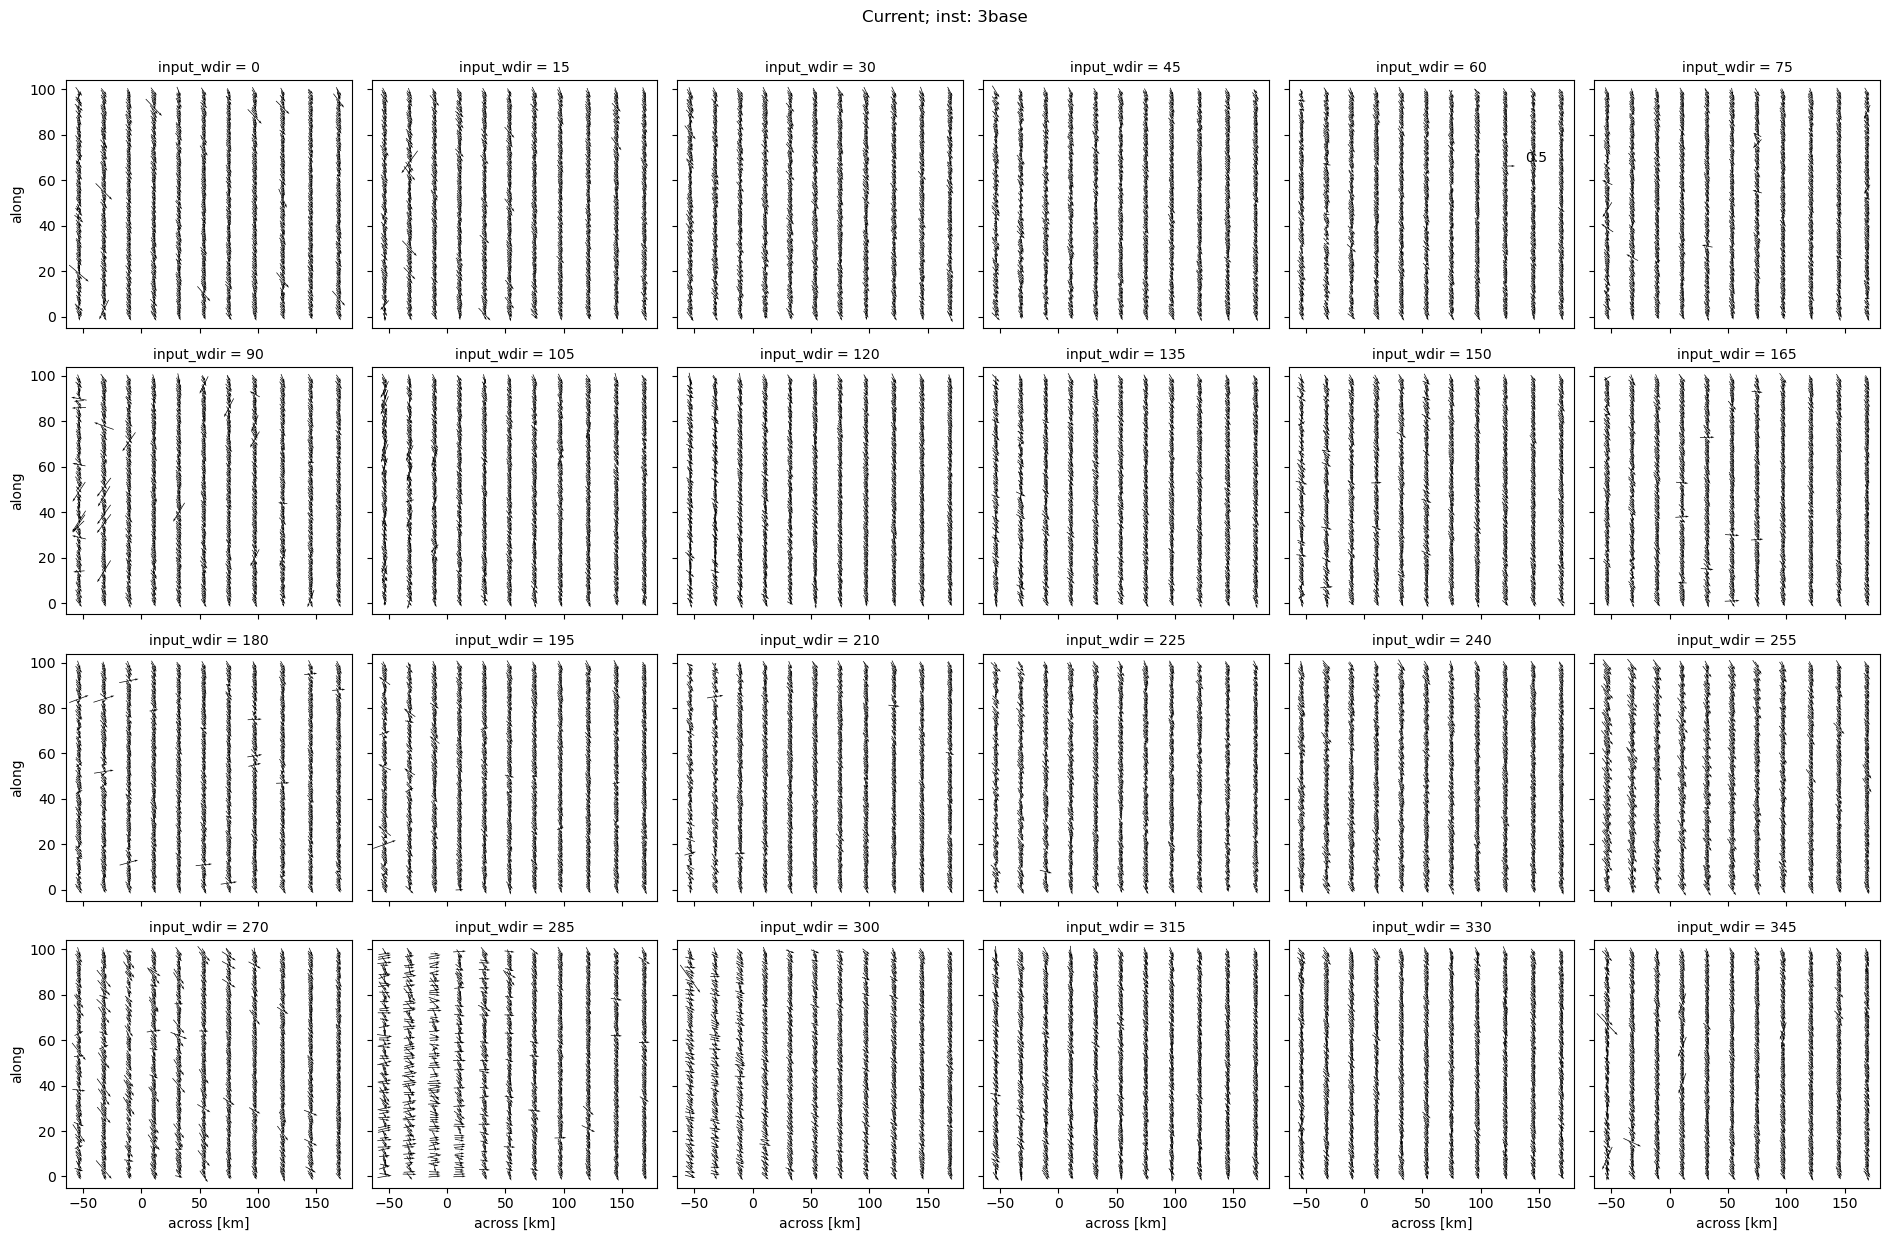

In [19]:
level2b.sel(ambiguity_names='current').plot.quiver(
    x='across',
    y='along',
    u='CurrentU',
    v='CurrentV',
    col='input_wdir', col_wrap=6, scale=20,
#     angles='uv',
#     hue='ambiguity_names', hue_style='discrete', add_guide='discrete',
)
plt.suptitle('Current' + '; inst: ' + nickname, y=1.03)

Text(0.5, 1.03, 'inst: 3base')

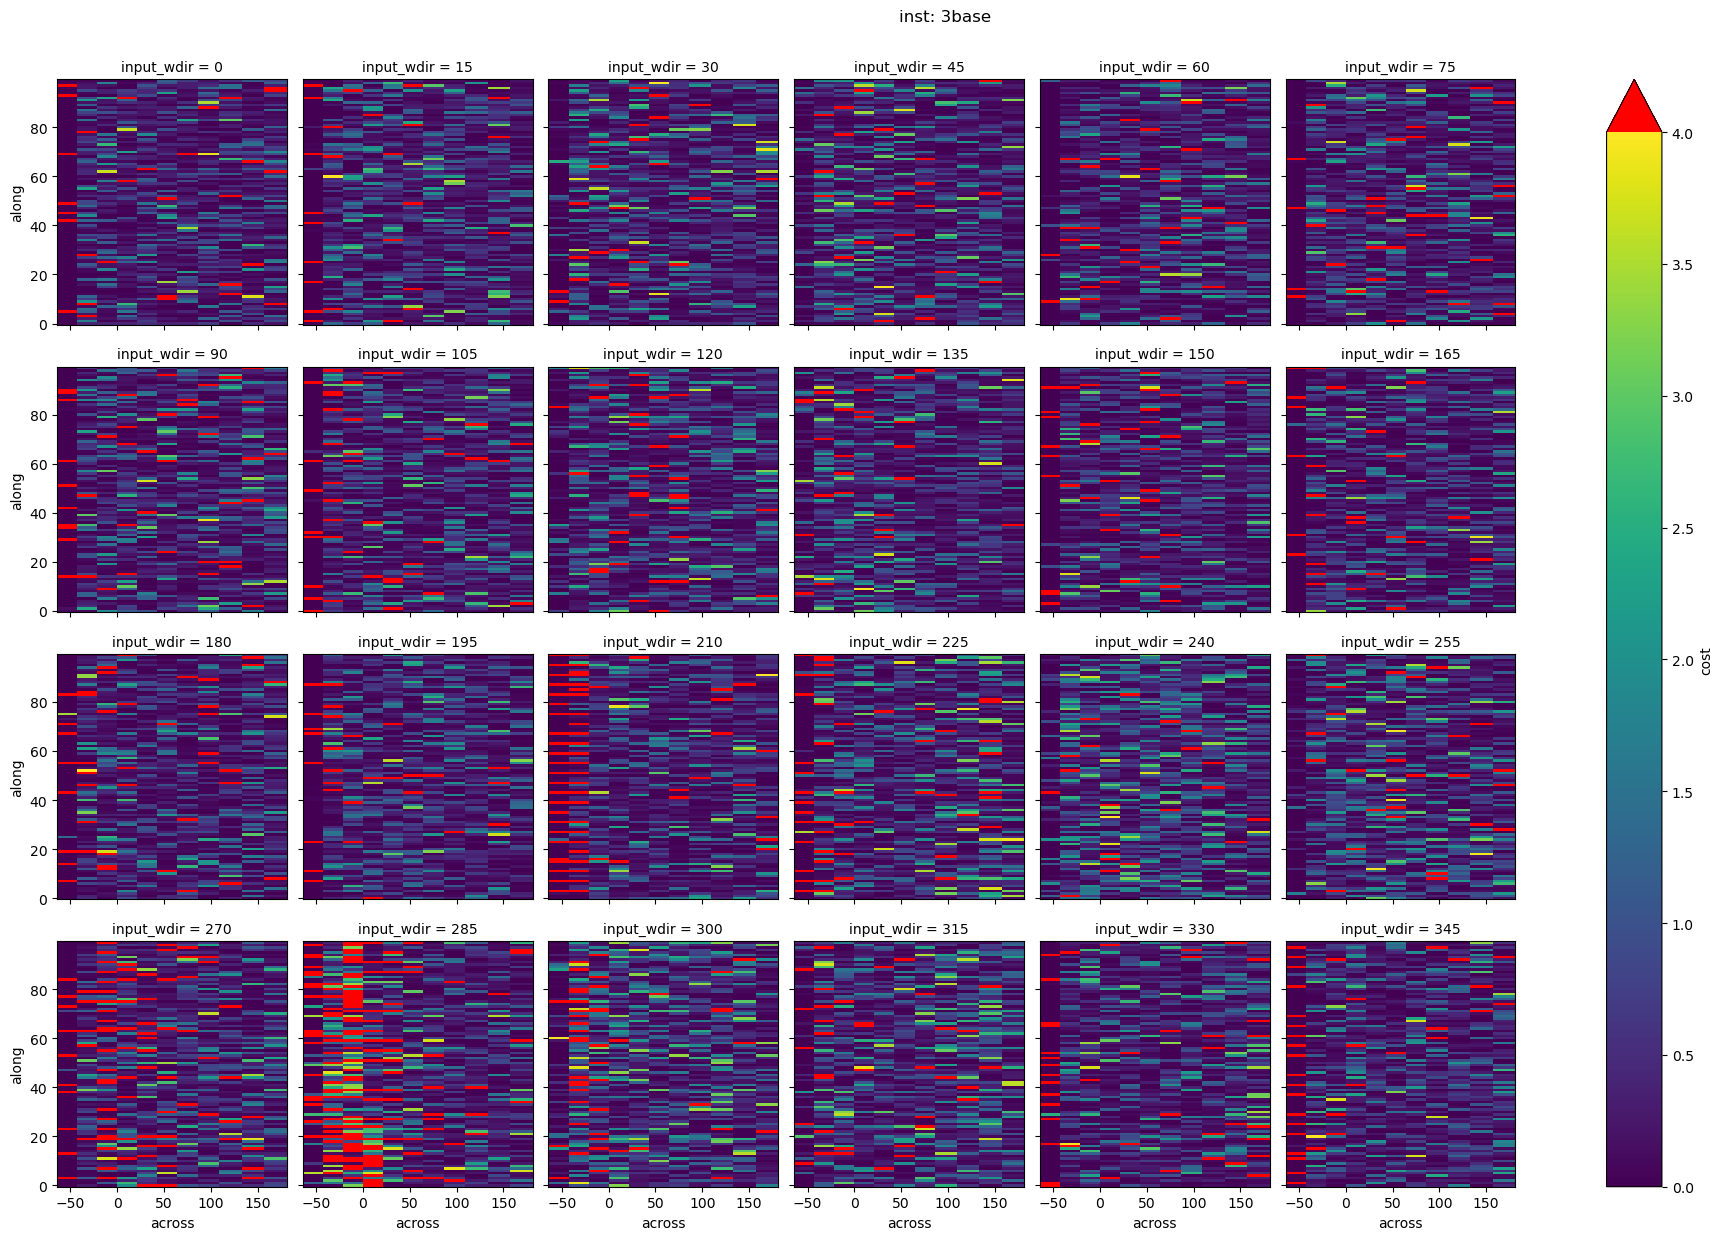

In [20]:
cmap = mpl.cm.viridis.copy()
cmap.set_over('red')
level2b.cost.sel(ambiguity_names='current')\
    .plot(x='across', vmax=4, cmap=cmap,
         col='input_wdir', col_wrap=6, )
plt.suptitle('inst: ' + nickname, y=1.03)

/var/folders/jj/tdmxyw195x511d7nbgk7y8fm0000gq/T/ipykernel_84317/3517965512.py:4: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(im)
/var/folders/jj/tdmxyw195x511d7nbgk7y8fm0000gq/T/ipykernel_84317/3517965512.py:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cbar.cmap.set_over('red')


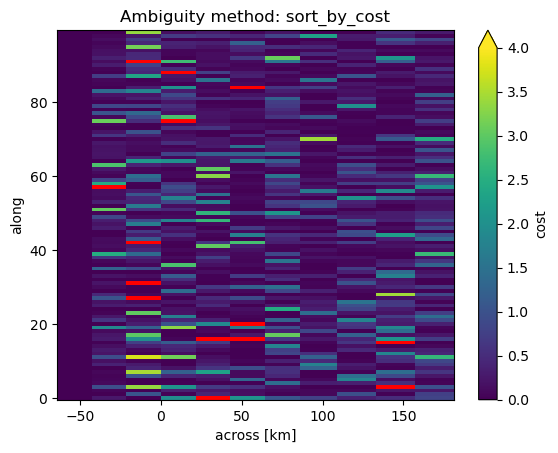

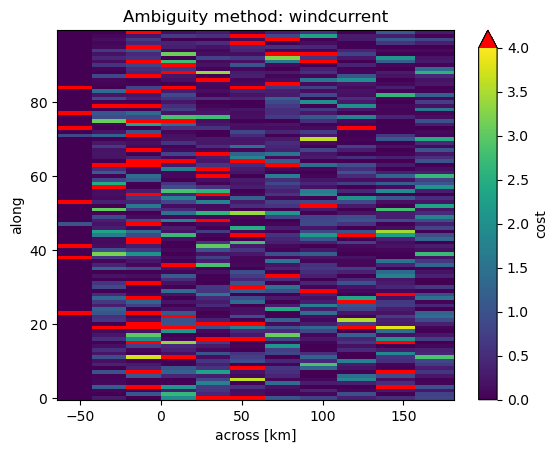

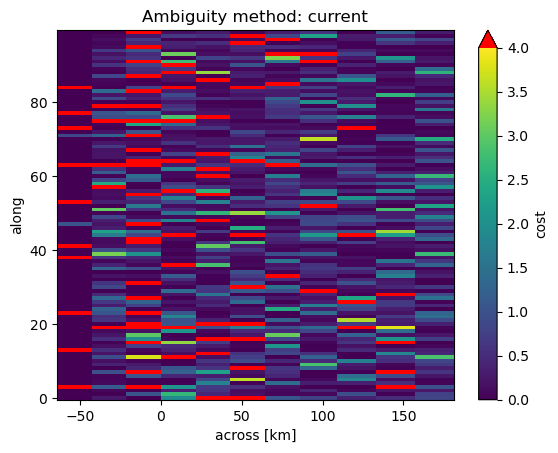

In [22]:
for amb in level2b.ambiguity_names.data:
    plt.figure()
    im = level2b.cost.sel(input_wdir=270).sel(ambiguity_names=amb).plot(x='across', vmax=4)
    cbar = fig.colorbar(im)
    cbar.cmap.set_over('red')
    plt.title('Ambiguity method: ' + amb)

Text(0.5, 1.0, 'Wind @270°; inst: 3base')

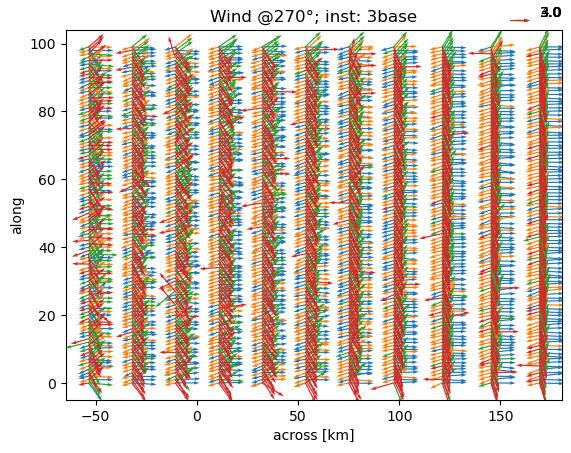

In [24]:
for ii in level2.Ambiguities.data:
    level2.sel(input_wdir=270).sel(Ambiguities=ii).plot.quiver(
        x='across',
        y='along',
        u='u',
        v='v',
        angles='uv',
        color='C'+str(ii), scale=100,
        pivot='tail',
    )
plt.title('Wind @270°' + '; inst: ' + nickname)

Text(0.5, 1.0, 'Current with wdir@270°; inst: 3base')

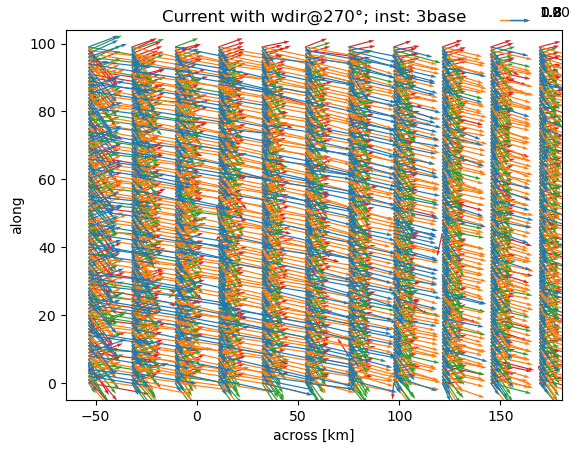

In [25]:
for ii in np.flip(level2.Ambiguities.data):
    level2.sel(input_wdir=270).sel(Ambiguities=ii).plot.quiver(
        x='across',
        y='along',
        u='c_u',
        v='c_v',
        angles='uv',
        color='C'+str(ii), scale=20,
        pivot='tail',
    )
plt.title('Current with wdir@270°' + '; inst: ' + nickname)